In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
integrade_data_raw = pd.read_csv('gex.combined.sct.csv')
integrade_meta_raw = pd.read_csv('gex.combined.sct.obs.csv')

In [25]:
integrade_data = integrade_data_raw
integrade_meta = integrade_meta_raw

In [26]:
integrade_data = integrade_data.transpose()

In [27]:
integrade_data = integrade_data.iloc[1:, :]

In [28]:
integrade_data.reset_index(drop=True, inplace=True)
integrade_data['batch'] = integrade_meta['batch']

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s4d1', 's4d8', 's4d9']

In [29]:
s1d1_integrade_data = integrade_data[integrade_data['batch'] == 's1d1']
s1d2_integrade_data = integrade_data[integrade_data['batch'] == 's1d2']
s1d3_integrade_data = integrade_data[integrade_data['batch'] == 's1d3']
s2d1_integrade_data = integrade_data[integrade_data['batch'] == 's2d1']
s2d4_integrade_data = integrade_data[integrade_data['batch'] == 's2d4']
s2d5_integrade_data = integrade_data[integrade_data['batch'] == 's2d5']
s3d1_integrade_data = integrade_data[integrade_data['batch'] == 's3d1']
s3d6_integrade_data = integrade_data[integrade_data['batch'] == 's3d6']
s3d7_integrade_data = integrade_data[integrade_data['batch'] == 's3d7']

In [30]:
s4d1_integrade_data = integrade_data[integrade_data['batch'] == 's4d1']
s4d8_integrade_data = integrade_data[integrade_data['batch'] == 's4d8']
s4d9_integrade_data = integrade_data[integrade_data['batch'] == 's4d9']

In [31]:
s1d1_inte_np = s1d1_integrade_data.iloc[:, :-1].to_numpy()
s1d2_inte_np = s1d2_integrade_data.iloc[:, :-1].to_numpy()
s1d3_inte_np = s1d3_integrade_data.iloc[:, :-1].to_numpy()
s2d1_inte_np = s2d1_integrade_data.iloc[:, :-1].to_numpy()
s2d4_inte_np = s2d4_integrade_data.iloc[:, :-1].to_numpy()
s2d5_inte_np = s2d5_integrade_data.iloc[:, :-1].to_numpy()
s3d1_inte_np = s3d1_integrade_data.iloc[:, :-1].to_numpy()
s3d6_inte_np = s3d6_integrade_data.iloc[:, :-1].to_numpy()
s3d7_inte_np = s3d7_integrade_data.iloc[:, :-1].to_numpy()

In [32]:
s4d1_inte_np = s4d1_integrade_data.iloc[:, :-1].to_numpy()
s4d8_inte_np = s4d8_integrade_data.iloc[:, :-1].to_numpy()
s4d9_inte_np = s4d9_integrade_data.iloc[:, :-1].to_numpy()

In [33]:
train_input_inte = np.concatenate([s1d1_inte_np, s1d2_inte_np, s1d3_inte_np, s2d1_inte_np, s2d4_inte_np, s2d5_inte_np, s3d1_inte_np, s3d6_inte_np, s3d7_inte_np], axis=0)
val_input_inte = np.concatenate([s3d1_inte_np, s3d6_inte_np, s3d7_inte_np], axis=0)
test_input_inte = np.concatenate([s4d1_inte_np, s4d8_inte_np, s4d9_inte_np], axis=0)

In [34]:
train_input = np.concatenate([train_input, train_input_inte], axis=1)
val_input = np.concatenate([val_input, val_input_inte], axis=1)
test_input = np.concatenate([test_input, test_input_inte], axis=1)

In [35]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(66175, 16953)
(28921, 16953)
(1000, 16953)


In [36]:
train_input = np.float64(train_input)
val_input = np.float64(val_input)
test_input = np.float64(test_input)

In [37]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [38]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [39]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [40]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [41]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [42]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [43]:
batch_train = batch_train + batch_val

In [44]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([66175, 1])

In [45]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([28921, 1])

In [46]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [47]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [48]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [49]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [50]:
PATH = 'No_norm_model_RNA_pro_with_inte'

In [51]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.32663023  Validation_loss:  0.2753988  Test_loss:  0.3081497


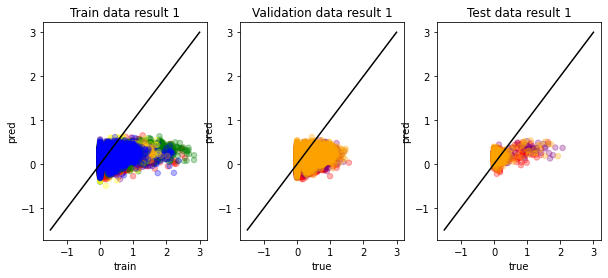

Epoch  100 Train_loss:  0.21694927  Validation_loss:  0.20969072  Test_loss:  0.19318536
Epoch  200 Train_loss:  0.20407918  Validation_loss:  0.2004695  Test_loss:  0.18552993
Epoch  300 Train_loss:  0.19592951  Validation_loss:  0.19438642  Test_loss:  0.18230025
Epoch  400 Train_loss:  0.18980396  Validation_loss:  0.18969552  Test_loss:  0.17936555
Epoch  500 Train_loss:  0.18470651  Validation_loss:  0.18556432  Test_loss:  0.1772861
Epoch  600 Train_loss:  0.1801896  Validation_loss:  0.18183474  Test_loss:  0.1760758
Epoch  700 Train_loss:  0.17603166  Validation_loss:  0.17831303  Test_loss:  0.17536733
Epoch  800 Train_loss:  0.17206393  Validation_loss:  0.17491713  Test_loss:  0.17397922
Epoch  900 Train_loss:  0.16822052  Validation_loss:  0.17153288  Test_loss:  0.17325544
Epoch  1000 Train_loss:  0.16444883  Validation_loss:  0.16818514  Test_loss:  0.17278679


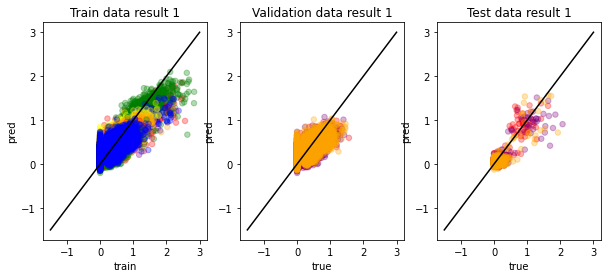

Epoch  1100 Train_loss:  0.16069199  Validation_loss:  0.16479085  Test_loss:  0.17230211
Epoch  1200 Train_loss:  0.15692793  Validation_loss:  0.16133669  Test_loss:  0.17165403
Epoch  1300 Train_loss:  0.15315779  Validation_loss:  0.15784389  Test_loss:  0.1715253
Epoch  1400 Train_loss:  0.14935173  Validation_loss:  0.15426385  Test_loss:  0.17124303
Epoch  1500 Train_loss:  0.14550418  Validation_loss:  0.15058707  Test_loss:  0.17100152
Epoch  1600 Train_loss:  0.14163825  Validation_loss:  0.14687769  Test_loss:  0.17086548
Epoch  1700 Train_loss:  0.13774247  Validation_loss:  0.14309506  Test_loss:  0.17063467
Epoch  1800 Train_loss:  0.13382705  Validation_loss:  0.13924861  Test_loss:  0.17051277
Epoch  1900 Train_loss:  0.12989838  Validation_loss:  0.13536288  Test_loss:  0.17072304
Epoch  2000 Train_loss:  0.12596457  Validation_loss:  0.13146205  Test_loss:  0.17084843


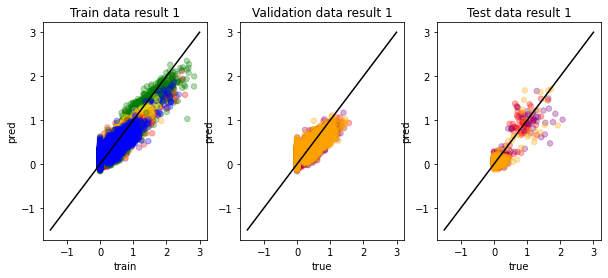

Epoch  2100 Train_loss:  0.12205859  Validation_loss:  0.12753576  Test_loss:  0.1711889
Epoch  2200 Train_loss:  0.118157946  Validation_loss:  0.123620614  Test_loss:  0.17102496
Epoch  2300 Train_loss:  0.114307895  Validation_loss:  0.11969146  Test_loss:  0.17136057
Epoch  2400 Train_loss:  0.11051479  Validation_loss:  0.115827836  Test_loss:  0.17158139
Epoch  2500 Train_loss:  0.10678498  Validation_loss:  0.1119847  Test_loss:  0.17162259
Epoch  2600 Train_loss:  0.10313328  Validation_loss:  0.108202755  Test_loss:  0.1719915
Epoch  2700 Train_loss:  0.09958697  Validation_loss:  0.104514554  Test_loss:  0.17204142
Epoch  2800 Train_loss:  0.09611953  Validation_loss:  0.10088089  Test_loss:  0.17243803
Epoch  2900 Train_loss:  0.092760816  Validation_loss:  0.09735725  Test_loss:  0.1724857
Epoch  3000 Train_loss:  0.089518115  Validation_loss:  0.09392661  Test_loss:  0.1727258


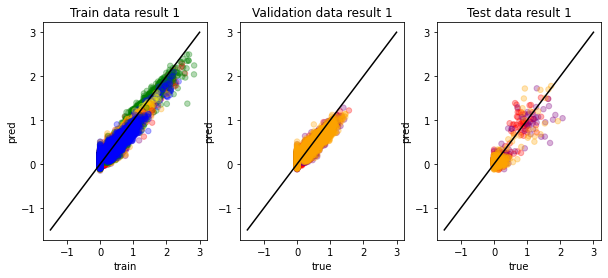

Epoch  3100 Train_loss:  0.086381905  Validation_loss:  0.090587795  Test_loss:  0.17284662
Epoch  3200 Train_loss:  0.08337603  Validation_loss:  0.08739505  Test_loss:  0.1730292
Epoch  3300 Train_loss:  0.0804846  Validation_loss:  0.08429915  Test_loss:  0.17317761
Epoch  3400 Train_loss:  0.077722065  Validation_loss:  0.08133233  Test_loss:  0.17350651
Epoch  3500 Train_loss:  0.075066276  Validation_loss:  0.078472264  Test_loss:  0.17362949
Epoch  3600 Train_loss:  0.07252632  Validation_loss:  0.07572709  Test_loss:  0.17373909
Epoch  3700 Train_loss:  0.07010116  Validation_loss:  0.07310364  Test_loss:  0.17392956
Epoch  3800 Train_loss:  0.067833446  Validation_loss:  0.07063614  Test_loss:  0.1741148
Epoch  3900 Train_loss:  0.065604515  Validation_loss:  0.06822129  Test_loss:  0.17433645
Epoch  4000 Train_loss:  0.06351517  Validation_loss:  0.065942444  Test_loss:  0.17425276


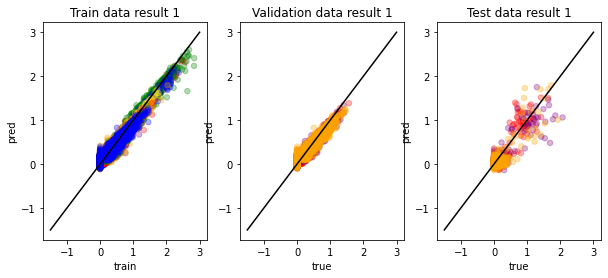

Epoch  4100 Train_loss:  0.06150709  Validation_loss:  0.063756235  Test_loss:  0.17427169
Epoch  4200 Train_loss:  0.059620082  Validation_loss:  0.061688505  Test_loss:  0.17439425
Epoch  4300 Train_loss:  0.057816107  Validation_loss:  0.05972204  Test_loss:  0.17440705
Epoch  4400 Train_loss:  0.05607597  Validation_loss:  0.05781632  Test_loss:  0.17448115
Epoch  4500 Train_loss:  0.05446567  Validation_loss:  0.056057733  Test_loss:  0.17449093
Epoch  4600 Train_loss:  0.0529255  Validation_loss:  0.05435397  Test_loss:  0.17458755
Epoch  4700 Train_loss:  0.051456455  Validation_loss:  0.052754678  Test_loss:  0.17450818
Epoch  4800 Train_loss:  0.050050795  Validation_loss:  0.051204443  Test_loss:  0.17460711
Epoch  4900 Train_loss:  0.048704363  Validation_loss:  0.049726255  Test_loss:  0.17465161
Epoch  5000 Train_loss:  0.04740843  Validation_loss:  0.048308767  Test_loss:  0.17442447


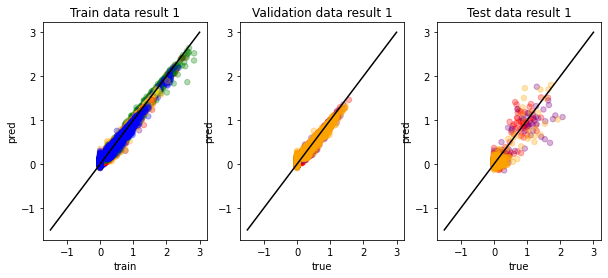

Epoch  5100 Train_loss:  0.04621514  Validation_loss:  0.046995685  Test_loss:  0.17458998
Epoch  5200 Train_loss:  0.045055747  Validation_loss:  0.045735635  Test_loss:  0.17458828
Epoch  5300 Train_loss:  0.043964975  Validation_loss:  0.044558294  Test_loss:  0.17465757
Epoch  5400 Train_loss:  0.042896867  Validation_loss:  0.043385074  Test_loss:  0.17457962
Epoch  5500 Train_loss:  0.041858323  Validation_loss:  0.042250678  Test_loss:  0.17458469
Epoch  5600 Train_loss:  0.040915895  Validation_loss:  0.04123687  Test_loss:  0.17469649
Epoch  5700 Train_loss:  0.039989743  Validation_loss:  0.040211312  Test_loss:  0.17468062
Epoch  5800 Train_loss:  0.039128028  Validation_loss:  0.039270885  Test_loss:  0.17471695
Epoch  5900 Train_loss:  0.03826901  Validation_loss:  0.038342424  Test_loss:  0.17465666
Epoch  6000 Train_loss:  0.03745473  Validation_loss:  0.037460446  Test_loss:  0.17444949


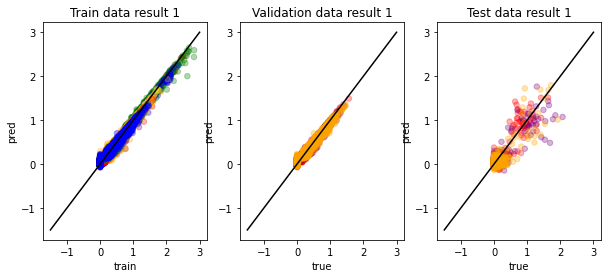

Epoch  6100 Train_loss:  0.036732838  Validation_loss:  0.036655545  Test_loss:  0.17466593
Epoch  6200 Train_loss:  0.03599909  Validation_loss:  0.0358725  Test_loss:  0.17449637
Epoch  6300 Train_loss:  0.03526462  Validation_loss:  0.035081245  Test_loss:  0.17442766
Epoch  6400 Train_loss:  0.03462751  Validation_loss:  0.0343958  Test_loss:  0.1745192
Epoch  6500 Train_loss:  0.033963878  Validation_loss:  0.033667956  Test_loss:  0.1743232
Epoch  6600 Train_loss:  0.033300772  Validation_loss:  0.03297456  Test_loss:  0.17439035
Epoch  6700 Train_loss:  0.032697354  Validation_loss:  0.03233028  Test_loss:  0.17434777
Epoch  6800 Train_loss:  0.03215339  Validation_loss:  0.03173318  Test_loss:  0.17427431
Epoch  6900 Train_loss:  0.031588126  Validation_loss:  0.031145502  Test_loss:  0.1741422
Epoch  7000 Train_loss:  0.031034907  Validation_loss:  0.030548101  Test_loss:  0.17423621


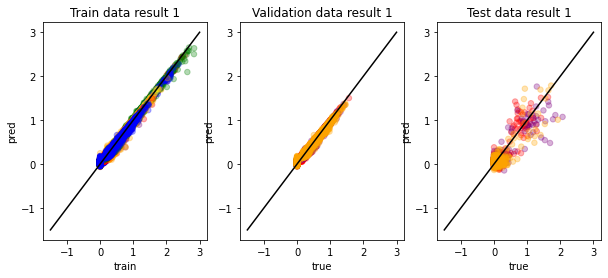

Epoch  7100 Train_loss:  0.03055271  Validation_loss:  0.030034157  Test_loss:  0.1742356
Epoch  7200 Train_loss:  0.030049242  Validation_loss:  0.029497838  Test_loss:  0.17408873
Epoch  7300 Train_loss:  0.029551085  Validation_loss:  0.028969692  Test_loss:  0.17409717
Epoch  7400 Train_loss:  0.029117716  Validation_loss:  0.028509865  Test_loss:  0.17415161
Epoch  7500 Train_loss:  0.028647088  Validation_loss:  0.028012563  Test_loss:  0.17419012
Epoch  7600 Train_loss:  0.028227543  Validation_loss:  0.027590731  Test_loss:  0.17415917
Epoch  7700 Train_loss:  0.027801014  Validation_loss:  0.02713607  Test_loss:  0.1741459
Epoch  7800 Train_loss:  0.027435293  Validation_loss:  0.026752327  Test_loss:  0.17399044
Epoch  7900 Train_loss:  0.02706166  Validation_loss:  0.026363298  Test_loss:  0.17387332
Epoch  8000 Train_loss:  0.026650062  Validation_loss:  0.02591085  Test_loss:  0.17418689


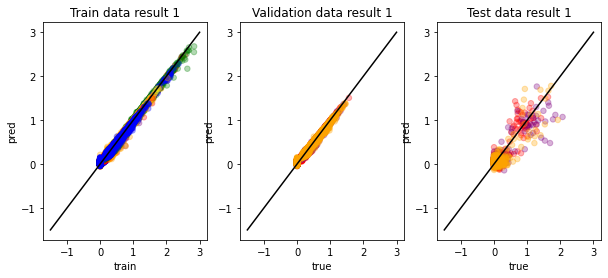

Epoch  8100 Train_loss:  0.026302062  Validation_loss:  0.02554566  Test_loss:  0.17396313
Epoch  8200 Train_loss:  0.025967304  Validation_loss:  0.025195623  Test_loss:  0.17406164
Epoch  8300 Train_loss:  0.025591198  Validation_loss:  0.024796719  Test_loss:  0.17396222
Epoch  8400 Train_loss:  0.025291877  Validation_loss:  0.02446961  Test_loss:  0.17397715
Epoch  8500 Train_loss:  0.024970252  Validation_loss:  0.024136383  Test_loss:  0.17395619
Epoch  8600 Train_loss:  0.024629077  Validation_loss:  0.023792453  Test_loss:  0.17393032
Epoch  8700 Train_loss:  0.024350982  Validation_loss:  0.023511047  Test_loss:  0.17389026
Epoch  8800 Train_loss:  0.02407461  Validation_loss:  0.023231797  Test_loss:  0.17384566
Epoch  8900 Train_loss:  0.023775013  Validation_loss:  0.02292351  Test_loss:  0.17373309
Epoch  9000 Train_loss:  0.023513794  Validation_loss:  0.022645094  Test_loss:  0.1737791


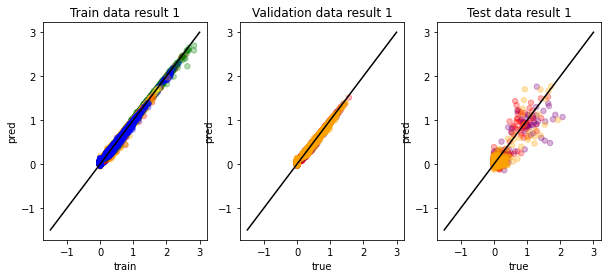

Epoch  9100 Train_loss:  0.02321903  Validation_loss:  0.022361679  Test_loss:  0.1736748
Epoch  9200 Train_loss:  0.022956656  Validation_loss:  0.022078656  Test_loss:  0.17380463
Epoch  9300 Train_loss:  0.022736138  Validation_loss:  0.021838345  Test_loss:  0.1735998
Epoch  9400 Train_loss:  0.022444643  Validation_loss:  0.021540942  Test_loss:  0.17369081
Epoch  9500 Train_loss:  0.022204882  Validation_loss:  0.021309666  Test_loss:  0.17372137
Epoch  9600 Train_loss:  0.021982249  Validation_loss:  0.021081742  Test_loss:  0.17369102
Epoch  9700 Train_loss:  0.021768883  Validation_loss:  0.020859819  Test_loss:  0.17361431
Epoch  9800 Train_loss:  0.021530546  Validation_loss:  0.020611318  Test_loss:  0.17345624
Epoch  9900 Train_loss:  0.021373585  Validation_loss:  0.020457575  Test_loss:  0.17376712
Epoch  10000 Train_loss:  0.021122403  Validation_loss:  0.02020866  Test_loss:  0.17367955


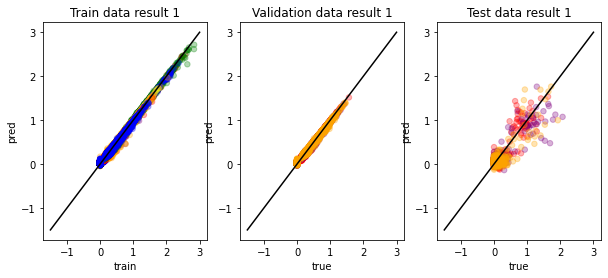

Epoch  10100 Train_loss:  0.02094039  Validation_loss:  0.020019079  Test_loss:  0.17362984
Epoch  10200 Train_loss:  0.020729683  Validation_loss:  0.019809786  Test_loss:  0.17357078
Epoch  10300 Train_loss:  0.020521969  Validation_loss:  0.01960696  Test_loss:  0.17340414
Epoch  10400 Train_loss:  0.020368123  Validation_loss:  0.019440042  Test_loss:  0.17365196
Epoch  10500 Train_loss:  0.020210475  Validation_loss:  0.019275237  Test_loss:  0.17356089
Epoch  10600 Train_loss:  0.019991407  Validation_loss:  0.019060614  Test_loss:  0.17351541
Epoch  10700 Train_loss:  0.019816551  Validation_loss:  0.018884597  Test_loss:  0.17356956
Epoch  10800 Train_loss:  0.019611303  Validation_loss:  0.018679556  Test_loss:  0.17346455
Epoch  10900 Train_loss:  0.019480962  Validation_loss:  0.018547192  Test_loss:  0.17347544


KeyboardInterrupt: 

In [52]:
num_epochs = 50000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)